In [117]:
## Importamos los modulos requeridos
from urllib.request import urlopen
#from bs4 import BeautifulSoup
import requests
import shutil, os
from pandas import Series, DataFrame 
import pandas as pd
import pathlib
pd.set_option('max_rows',100000)
pd.set_option('max_colwidth',100000)
import urllib.request
import webbrowser
import re
import numpy as np
from time import sleep
import subprocess
from subprocess import Popen, PIPE, STDOUT
import shutil
from IPython.display import Image
from IPython.core.display import HTML

In [118]:
Image(url= "https://raw.githubusercontent.com/eduardo1011/Programas/master/Anotacion_funcional_diag.png")

In [119]:
Image(url= "https://raw.githubusercontent.com/eduardo1011/Programas/master/Anotacion_funcional_GO.png")

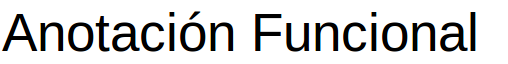

# 1. Anotacion de productos de genes
# 2. Gráficos en R<br/>

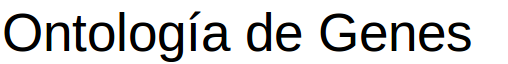

# IMPORTANTE
## Archivos requeridos para la Ontologia 
>### 1.- go.obo
>### 2.- OWLTools (Map2Slim)
>### 3.- GO slim (Generico)
>### 4.- Proteoma en estudio (IDs Uniprot)
>### 5.- Archivo en formato GAF (Gene Association Format, GOC)

# 1.- Descargas (go.obo, OWLTools y GO slim)<br/>

In [121]:
if os.path.exists("../data/Experimento1_GOslim/go.obo"): 
    print ('■■■ El archivo go.obo ya existe, no se descargará de la red')
else:
    ## descarga de la ontologia de genes
    output1=urllib.request.urlretrieve('http://snapshot.geneontology.org/ontology/go.obo','../data/Experimento1_GOslim/go.obo')
if os.path.exists("../data/Experimento1_GOslim/owltools"):
    print ('■■■ El programa owltools ya existe, no se descargará de la red')
else: 
    ## descarga de owltools, una herramienta multitarea, una de ellas es hacer GO_slim
    output2=urllib.request.urlretrieve('http://build.berkeleybop.org/userContent/owltools/owltools','../data/Experimento1_GOslim/owltools')
    ## damos permisos de ejecucion a owltools
    !chmod +x ../data/Experimento1_GOslim/owltools
if os.path.exists("../data/Experimento1_GOslim/goslim_plant.txt"):
    print ('■■■ El archivo goslim_plant.txt ya existe, no se descargará de la red')
else:
    ## descargamos el go-slim desde el Gene Ontology Consortium
    output3=urllib.request.urlretrieve('http://www.geneontology.org/ontology/subsets/goslim_plant.obo','../data/Experimento1_GOslim/goslim_plant.obo')
    ## Ahora le hacemos una ligera edicion para obtener tres columnas: GO ID, término y aspecto
    Popen("grep -e '^id: GO:' -e '^name: ' -e '^namespace: ' -e '.Typedef.' ../data/Experimento1_GOslim/goslim_plant.obo | sed 's/id:/#id:/g' | perl -p -e 's/\n/\t/g' | sed 's/.Typedef.*//g' | perl -p -e 's/#/\n/g' | sed 's/id: //g; s/name: //g; s/namespace: //g' | sed '/^$/d' | sed 's/\t$//g' | sed 's/biological_process/P/g; s/molecular_function/F/g; s/cellular_component/C/g' | grep -v -e '\tC\tC' -v -e '\tF\tF' -v -e '\tP\tP'  > ../data/Experimento1_GOslim/goslim_plant.txt",
          shell=True, stdin=PIPE, stdout=PIPE, stderr=STDOUT, close_fds=True).stdout.read()
    if os.path.exists("../data/Experimento1_GOslim/goslim_plant.obo"): os.remove("../data/Experimento1_GOslim/goslim_plant.obo")


■■■ El archivo go.obo ya existe, no se descargará de la red
■■■ El programa owltools ya existe, no se descargará de la red
■■■ El archivo goslim_plant.txt ya existe, no se descargará de la red


# 2.- Proteoma en estudio (IDs Uniprot) 
>## La lista de IDs de proteinas se obtuvo del siguiente articulo ( *Zea mays* , Maize)
https://www.ncbi.nlm.nih.gov/pubmed/29358734

In [122]:
Image(url= "https://raw.githubusercontent.com/eduardo1011/Programas/master/zea.png")

In [124]:
## contamos los IDs de las proteinas y vemos la lista 
## La descargamos de github
output=urllib.request.urlretrieve('https://raw.githubusercontent.com/eduardo1011/Programas/master/zea','../data/Experimento1_GOslim/zea')
## la guardamos en una variable
proteome_list=pd.read_csv('../data/Experimento1_GOslim/zea',header=None,names=['Entry'])
print('\n','Numero total de proteinas: ',proteome_list['Entry'].count(),'\n')
print(proteome_list[1:10],'\n..........\n')


 Numero total de proteinas:  700 

        Entry
1  A0A1D6JWH5
2  A0A1D6JWH6
3  A0A1D6JWH7
4      C0P3W9
5  A0A1D6N0R1
6      Q9SLP5
7      C0PHG6
8      Q768R3
9  A0A1D6N1Z8 
..........



## 3.- Obtencion del archivo GAF desde la base de datos de EMBL-EBI (Uniprot-GOA) y edicion (obtencion de ID y GO ID a partir del GAF)

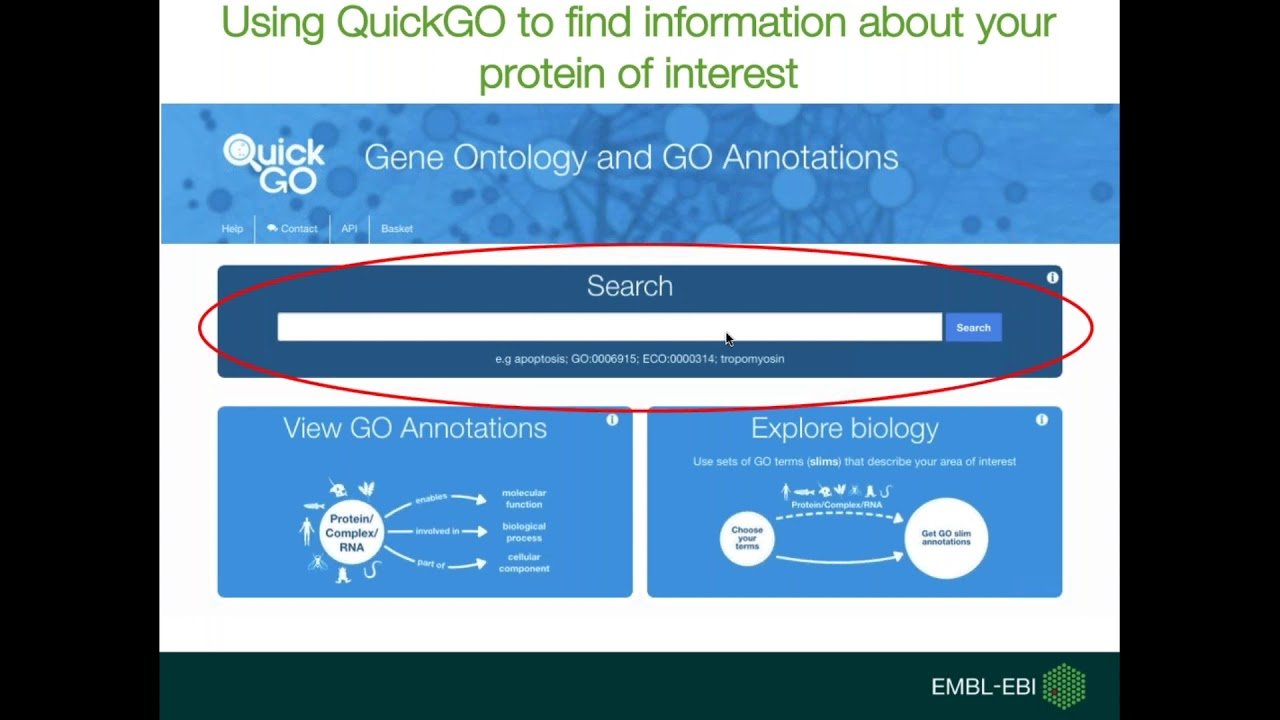

In [125]:
Image("https://i.ytimg.com/vi/Pa5Ll8WByr4/maxresdefault.jpg")

### Busqueda automatica del organismo en estudio<br/>

In [126]:
## Se extrae el primer identificador de la lista de proteínas
first_entry=proteome_list['Entry'].iloc[0]

## Con el identificador de la proteína obtenemos el "organism" y el "id-organism" desde Uniprot con este comando
organism=requests.get("https://www.uniprot.org/uniprot/?query="+first_entry+"&sort=score&columns=organism&format=tab&limit=1").content.decode()
organismo=DataFrame(re.findall('[A-Z].*',organism))[0].iloc[1]

## id-organism (este id nos sirve para descargar el archivo GAF)
id_organism = requests.get("https://www.uniprot.org/uniprot/?query="+first_entry+"&sort=score&columns=organism-id,organism&format=tab&limit=1").content.decode()
id_organism=DataFrame(re.findall('[0-9]{1,30}',id_organism))[0].iloc[0]

print('\nOrganism:             ',organismo,'\n')
print('Taxonomic identifier: ',id_organism,'\n') 


Organism:              Zea mays (Maize) 

Taxonomic identifier:  4577 



In [127]:
## Descarga del archivo con todas las anotaciones (GAF) del organismos identificado

## Registra el total de organismos en la base de datos
goa_proteomes = urllib.request.urlretrieve('https://www.ebi.ac.uk/inc/drupal/goa/proteomes_release.html', '../data/Experimento1_GOslim/goa_proteomes')

## Conversión html a tsv
out1 = Popen('sed "s/\t//g; s/<[^>]*>/#/g; s/#\{1,7\}/#/g; s/^[#]//g; 1,3d; s/#/\t/g" ../data/Experimento1_GOslim/goa_proteomes | cut -f1-6 > ../data/Experimento1_GOslim/salida',
                shell=True, stdin=PIPE, stdout=PIPE, stderr=STDOUT, close_fds=True).stdout.read()

## Encuentra el id-"organism" y más información como el directorio para descarga
goa_id_organism = Popen('grep '+'^'+id_organism+' ../data/Experimento1_GOslim/salida | cut -f3',
                shell=True, stdin=PIPE, stdout=PIPE, stderr=STDOUT, close_fds=True).stdout.read().decode()
goa_id_organism=re.sub("\n",'',goa_id_organism)
##
## Control de la descarga del archivo GAF desde Uniprot-GOA
if goa_id_organism == '':
    print('\n!!!!!!! ID-Organism not found in GOA-Uniprot (Complete Annotation) !!!!!!!\n')
    if os.path.exists("../data/Experimento1_GOslim/goa_proteomes"): os.remove("../data/Experimento1_GOslim/goa_proteomes")
    if os.path.exists("../data/Experimento1_GOslim/salida"): os.remove("../data/Experimento1_GOslim/salida")
else:
    ## Descarga del archivo GAF desde Uniprot-GOA
    out2 =urllib.request.urlretrieve("ftp://ftp.ebi.ac.uk/pub/databases/GO/goa/proteomes/20180622/"+goa_id_organism+'.gz', '../data/Experimento1_GOslim/'+goa_id_organism+'.gz')
    out3 = Popen("gzip -d ../data/Experimento1_GOslim/"+goa_id_organism+".gz",
                shell=True, stdin=PIPE, stdout=PIPE, stderr=STDOUT, close_fds=True).stdout.read()
    ## removemos filas que empiezan con el caracter "!"
    out3 = Popen("sed -i 's/^!.*//g;/^$/d' ../data/Experimento1_GOslim/"+goa_id_organism,
                shell=True, stdin=PIPE, stdout=PIPE, stderr=STDOUT, close_fds=True).stdout.read()
    if os.path.exists("../data/Experimento1_GOslim/goa_proteomes"): os.remove("../data/Experimento1_GOslim/goa_proteomes")
    if os.path.exists("../data/Experimento1_GOslim/salida"): os.remove("../data/Experimento1_GOslim/salida")

In [128]:
## plan B por si el anterior no funciona (que no tenga contenido la URL o esté en actualizacion la pagina)
#wget ftp://ftp.geneontology.org/go/ontology/go.obo -O data/go.obo
#!wget "ftp://ftp.ebi.ac.uk/pub/databases/GO/goa/proteomes/20180622/71242.S_cerevisiae_ATCC_204508.goa.gz" -O ../data/Experimento1_GOslim/71242.S_cerevisiae_ATCC_204508.goa.gz
#!gzip -d ../data/Experimento1_GOslim/*.gz

## 4.- Anotacion usando Map2Slim: una opcion de OWLTools
>### Map2slim usa un fichero GO slim y un fichero .GAF, el script mapea los terminos del .GAF (anotacion completa) en los terminos del  GO slim creando una version corta de la ontologia.

### A partir del fichero GAF (gene association files) creamos el GO slim buscando los padres de cada término

In [129]:
## ejecutamos owltools
goslim =Popen("../data/Experimento1_GOslim/owltools ../data/Experimento1_GOslim/go.obo --gaf ../data/Experimento1_GOslim/272950.Z_mays_1.goa --map2slim --idfile ../data/Experimento1_GOslim/goslim_plant.txt --write-gaf ../data/Experimento1_GOslim/my.gaf", shell=True,
               stdin=PIPE, stdout=PIPE, stderr=STDOUT, close_fds=True).stdout.read()

In [130]:
## filtramos filas sin ! (caracteristico de ficheros GAF) y extraemos las columnas 2 y 5 con qacc y GO
output7 = Popen("grep -v '!' ../data/Experimento1_GOslim/my.gaf | cut -f2,5 > ../data/Experimento1_GOslim/slim", shell=True,
                stdin=PIPE, stdout=PIPE, stderr=STDOUT, close_fds=True).stdout.read()
## abrimos el fichero slim y lo asignamos
my_gaf_goslim=pd.read_table('../data/Experimento1_GOslim/slim', names=['Entry','GO']).drop_duplicates()
print(my_gaf_goslim.count(),'\n')
print(my_gaf_goslim[1:10])

Entry    218238
GO       218238
dtype: int64 

         Entry          GO
1   A0A060CVD8  GO:0003677
4   A0A060CVD8  GO:0003700
5   A0A060CVD8  GO:0005634
8   A0A060CVD8  GO:0006139
9   A0A060CVD8  GO:0009058
18  A0A060CVG2  GO:0006139
19  A0A060CVG2  GO:0009058
22  A0A060CVJ8  GO:0005515
23  A0A060CVL0  GO:0003677


In [131]:
## abrimos el GO slim editado (plant en este caso) y lo asignamos a una variable
goslim_specific=pd.read_table('../data/Experimento1_GOslim/goslim_plant.txt',names=['GO','Term','Aspect'])
goslim_specific.head()

,GO,Term,Aspect
0,GO:0000003,reproduction,P
1,GO:0000166,nucleotide binding,F
2,GO:0003676,nucleic acid binding,F
3,GO:0003677,DNA binding,F
4,GO:0003682,chromatin binding,F


### Ahora asignaremos el GO a cada proteina del proteoma en estudio

In [134]:
proteome_go=pd.merge(proteome_list,my_gaf_goslim,on="Entry",how='left')
proteome_go.head()

,Entry,GO
0,A0A1D6JWH4,GO:0003824
1,A0A1D6JWH4,GO:0000166
2,A0A1D6JWH4,GO:0009058
3,A0A1D6JWH4,GO:0005975
4,A0A1D6JWH4,GO:0016301


In [135]:
proteome_go['Entry'].drop_duplicates().count()

700

In [137]:
## asignacion de terminos y aspecto a cada proteina del proteoma en estudio
#*** Recordar que los terminos y aspectos corresponden al GO slim de plantas que en total son 96 terminos
proteome_go_term=pd.merge(proteome_go,goslim_specific,on="GO",how='left').drop_duplicates()#.fillna('N')
proteome_go_term.head()

,Entry,GO,Term,Aspect
0,A0A1D6JWH4,GO:0003824,catalytic activity,F
1,A0A1D6JWH4,GO:0000166,nucleotide binding,F
2,A0A1D6JWH4,GO:0009058,biosynthetic process,P
3,A0A1D6JWH4,GO:0005975,carbohydrate metabolic process,P
4,A0A1D6JWH4,GO:0016301,kinase activity,F


In [138]:
## analisis descriptivo
proteome_go_term.describe(include='all')

,Entry,GO,Term,Aspect
count,2534,2519,2519,2519
unique,700,52,52,3
top,A1XCI1,GO:0003824,catalytic activity,F
freq,11,253,253,1093


# Resultados
### Ahora extraemos las proteinas y sus categorias<br/>

## Funcion molecular

In [139]:
## Molecular Function
func=proteome_go_term[['GO','Term','Aspect']].groupby(['Aspect']).get_group('F')
function=func.groupby(['GO','Term']).count().reset_index().rename(columns={"Term": "Molecular Function","Aspect": "Value"}).sort_values(by ='Value',ascending=False).reset_index(drop=True)
mayor_A_10=function[(function.Value >= 10)]
menor_A_10=function[(function.Value < 10)]
otros_terminos={'GO':['GOs'],'Molecular Function':['Other Functions'],'Value':[sum(menor_A_10.Value)]}
terminos=pd.DataFrame(otros_terminos)
others=pd.concat([mayor_A_10,terminos[['GO','Molecular Function','Value']]],axis=0)
others.to_csv('../data/Experimento1_GOslim/Molecular_Function.csv',index=None)
others#.head()

,GO,Molecular Function,Value
0,GO:0003824,catalytic activity,253
1,GO:0000166,nucleotide binding,214
2,GO:0005488,binding,174
3,GO:0016740,transferase activity,132
4,GO:0016787,hydrolase activity,56
5,GO:0005515,protein binding,54
6,GO:0005215,transporter activity,52
7,GO:0003677,DNA binding,41
8,GO:0008135,"translation factor activity, RNA binding",34
9,GO:0003723,RNA binding,29


In [140]:
## matriz para ver intersecciones entre terminos
up_function=proteome_go_term[proteome_go_term.Aspect.str.contains("F")==True]
upset_function=up_function.pivot_table(values="Term",index=["Entry"],aggfunc=len,columns="GO").fillna('0').reset_index()
upset_function.to_csv('../data/Experimento1_GOslim/Molecular_Function_matrix.csv',index=None)
upset_function.head()

GO,Entry,GO:0000166,GO:0003676,GO:0003677,GO:0003682,GO:0003700,GO:0003723,GO:0003824,GO:0005198,GO:0005215,GO:0005488,GO:0005515,GO:0008135,GO:0016301,GO:0016740,GO:0016787,GO:0030246
0,A0A060D8P6,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,A0A096R382,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
2,A0A096RRR4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,A0A1D6DVH5,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
4,A0A1D6DVH6,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0


## Proceso biologico

In [141]:
## Biological Process
pros=proteome_go_term[['GO','Term','Aspect']].groupby(['Aspect']).get_group('P')
process=pros.groupby(['GO','Term']).count().reset_index().rename(columns={"Term": "Biological Process","Aspect": "Value"}).sort_values(by ='Value',ascending=False).reset_index(drop=True)
mayor_A_10=process[(process.Value >= 20)]
menor_A_10=process[(process.Value < 20)]
otros_terminos={'GO':['GOs'],'Biological Process':['Other Processes'],'Value':[sum(menor_A_10.Value)]}
terminos=pd.DataFrame(otros_terminos)
others=pd.concat([mayor_A_10,terminos[['GO','Biological Process','Value']]],axis=0)
others.to_csv('../data/Experimento1_GOslim/Biological_Process.csv',index=None)
others#.head()

,GO,Biological Process,Value
0,GO:0009987,cellular process,192
1,GO:0008152,metabolic process,169
2,GO:0009058,biosynthetic process,163
3,GO:0006139,nucleobase-containing compound metabolic process,88
4,GO:0006629,lipid metabolic process,69
5,GO:0005975,carbohydrate metabolic process,67
6,GO:0006810,transport,60
7,GO:0006091,generation of precursor metabolites and energy,60
8,GO:0016043,cellular component organization,48
9,GO:0006464,cellular protein modification process,30


In [142]:
## matriz para ver intersecciones entre terminos
up_process=proteome_go_term[proteome_go_term.Aspect.str.contains("P")==True]
upset_process=up_process.pivot_table(values="Term",index=["Entry"],aggfunc=len,columns="GO").fillna('0').reset_index()
upset_process.to_csv('../data/Experimento1_GOslim/Biological_Process_matrix.csv',index=None)
upset_process.head()

GO,Entry,GO:0005975,GO:0006091,GO:0006139,GO:0006259,GO:0006464,GO:0006629,GO:0006810,GO:0006950,GO:0008152,...,GO:0009605,GO:0009607,GO:0009628,GO:0009719,GO:0009987,GO:0015979,GO:0016043,GO:0019538,GO:0019725,GO:0040029
0,A0A096R382,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,A0A1D6DVH5,0,0,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,A0A1D6DVH6,0,0,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0
3,A0A1D6DVH7,0,0,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,A0A1D6DVI1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


## Componente celular

In [143]:
## Cellular Component
comp=proteome_go_term[['GO','Term','Aspect']].groupby(['Aspect']).get_group('C')
component=comp.groupby(['GO','Term']).count().reset_index().rename(columns={"Term": "Cellular Component","Aspect": "Value"}).sort_values(by ='Value',ascending=False).reset_index(drop=True)
mayor_A_10=component[(component.Value >= 5)]
menor_A_10=component[(component.Value < 5)]
otros_terminos={'GO':['GOs'],'Cellular Component':['Other Components'],'Value':[sum(menor_A_10.Value)]}
terminos=pd.DataFrame(otros_terminos)
others=pd.concat([mayor_A_10,terminos[['GO','Cellular Component','Value']]],axis=0)
others.to_csv('../data/Experimento1_GOslim/Cellular_Component.csv',index=None)
others#.head()

,GO,Cellular Component,Value
0,GO:0016020,membrane,96
1,GO:0005634,nucleus,69
2,GO:0005737,cytoplasm,54
3,GO:0005622,intracellular,36
4,GO:0009536,plastid,36
5,GO:0005840,ribosome,17
6,GO:0005739,mitochondrion,14
7,GO:0005783,endoplasmic reticulum,14
8,GO:0009579,thylakoid,14
9,GO:0005886,plasma membrane,10


In [144]:
## matriz para ver intersecciones entre terminos
up_component=proteome_go_term[proteome_go_term.Aspect.str.contains("C")==True]
upset_component=up_component.pivot_table(values="Term",index=["Entry"],aggfunc=len,columns="GO").fillna('0').reset_index()
upset_component.to_csv('../data/Experimento1_GOslim/Cellular_Component_matrix.csv',index=None)
upset_component.head()

GO,Entry,GO:0005576,GO:0005622,GO:0005623,GO:0005634,GO:0005654,GO:0005737,GO:0005739,GO:0005783,GO:0005829,GO:0005840,GO:0005856,GO:0005886,GO:0009536,GO:0009579,GO:0016020
0,A0A060D8P6,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,A0A096RRR4,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
2,A0A1D6DXB0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0
3,A0A1D6DXC1,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0
4,A0A1D6DXC2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


## 5.- Proteinas anotadas y no anotadas

In [150]:
## de todas las proteinas sabemos cuantas tienen anotacion en Uniprot
nan=proteome_go_term[proteome_go_term['GO'].isnull()].reset_index(drop=True) ## proteinas que no tienen GO
print('\nProteinas no anotadas: ',nan['Entry'].drop_duplicates().count(),'\n')
print(nan[['Entry']].drop_duplicates().reset_index(drop=True))


Proteinas no anotadas:  15 

         Entry
0   A0A1D6HU95
1   A0A1D6HU97
2   A0A1D6HU98
3   A0A1D6QI29
4   A0A1D6QI34
5       C0PJ67
6   A0A1D6I8L5
7   A0A1D6E367
8   A0A1D6E368
9       C0P6V3
10  A0A1D6MVE8
11  A0A1D6KGG5
12  A0A1D6KWX0
13  A0A1D6P836
14  A0A1D6P844


In [151]:
## solo las proteinas que tienen GO
no_nan=proteome_go_term[proteome_go_term['GO'].notnull()].reset_index(drop=True) 
print('\nProreinas anotadas: ',no_nan['Entry'].drop_duplicates().count(),'\n')
print(no_nan[['Entry']].drop_duplicates().reset_index(drop=True)[1:10])


Proreinas anotadas:  685 

        Entry
1  A0A1D6JWH5
2  A0A1D6JWH6
3  A0A1D6JWH7
4      C0P3W9
5  A0A1D6N0R1
6      Q9SLP5
7      C0PHG6
8      Q768R3
9  A0A1D6N1Z8


In [152]:
sin_con=[nan['Entry'].drop_duplicates().reset_index(drop=True).rename(),no_nan['Entry'].drop_duplicates().reset_index(drop=True).rename()]
singo_congo=pd.concat(sin_con, axis=1,ignore_index=False).rename(columns={0:'Without GO',1:'Whith GO'},index=str, inplace=False)
singo_congo.count().to_csv('../data/Experimento1_GOslim/Anotadas.csv')
singo_congo[['Without GO','Whith GO']].count()

Without GO     15
Whith GO      685
dtype: int64

In [153]:
sin_nan=no_nan[['Entry','GO','Term','Aspect']].drop_duplicates()
frec=sin_nan.pivot_table(values="GO",index=["Entry"],aggfunc=len,columns="Aspect").reset_index()
#frec.to_csv('./results/Categories_frequences.csv',header=True,index=None)
frec[['F','C','P']].count().to_csv('../data/Experimento1_GOslim/Total_categories_CFP.csv',header=None)
frec[['F','C','P']].count()

Aspect
F    651
C    279
P    504
dtype: int64

In [154]:
## Archivo para generar un diagrama de Venn, intersecciones entre categorias, total de proteinas por categoria
ff=proteome_go_term[proteome_go_term.Aspect.str.contains("F")==True]
pp=proteome_go_term[proteome_go_term.Aspect.str.contains("P")==True]
cc=proteome_go_term[proteome_go_term.Aspect.str.contains("C")==True]
cats=[pp[['Entry']],ff[['Entry']],cc[['Entry']]]
categorias=pd.concat(cats, axis=1, ignore_index=True).rename(columns={0:"Process",1:'Function',2:'Component'},index=str).drop_duplicates().reset_index(drop=True)
categorias.to_csv('../data/Experimento1_GOslim/cats.csv',index=None) 
categorias.head()

,Process,Function,Component
0,NaN,A0A1D6JWH4,NaN
1,A0A1D6JWH4,NaN,NaN
2,NaN,A0A1D6JWH5,NaN
3,A0A1D6JWH5,NaN,NaN
4,NaN,A0A1D6JWH6,NaN


## Informacion de uniprot

In [155]:
output=urllib.request.urlretrieve('https://raw.githubusercontent.com/eduardo1011/Programas/master/Retrieve--information-id_from_IDUniprot.pl','../data/Experimento1_GOslim/Retrieve--information-id_from_IDUniprot.pl')

In [156]:
no_nan[['Entry']].drop_duplicates().to_csv('../data/Experimento1_GOslim/IDs.csv',index=None,header=None)

In [157]:
out3 = Popen("perl ../data/Experimento1_GOslim/Retrieve--information-id_from_IDUniprot.pl ../data/Experimento1_GOslim/IDs.csv > ../data/Experimento1_GOslim/IDs_information_uniprot.tab",
             shell=True, stdin=PIPE, stdout=PIPE, stderr=STDOUT, close_fds=True).stdout.read()

In [159]:
orden_columnas=[0,1,2,3,4]
names=['Entry','Protein name','Gene name','Organism','Organism ID']
informacion=pd.read_csv('../data/Experimento1_GOslim/IDs_information_uniprot.tab',sep='\t',usecols=orden_columnas)
informacion

,Entry,Protein names,Gene names,Organism,Organism ID
0,A0A1D6JWH4,Phosphoenolpyruvate carboxykinase1,541622 ZEAMMB73_Zm00001d028471,Zea mays (Maize),4577
1,A0A1D6JWH5,Phosphoenolpyruvate carboxykinase1,541622 ZEAMMB73_Zm00001d028471,Zea mays (Maize),4577
2,A0A1D6JWH6,Phosphoenolpyruvate carboxykinase1,541622 ZEAMMB73_Zm00001d028471,Zea mays (Maize),4577
3,A0A1D6JWH7,Phosphoenolpyruvate carboxykinase1,541622 ZEAMMB73_Zm00001d028471,Zea mays (Maize),4577
4,C0P3W9,Phosphoenolpyruvate carboxykinase1,541622 ZEAMMB73_Zm00001d028471,Zea mays (Maize),4577
5,A0A1D6N0R1,"Ferredoxin--NADP reductase, chloroplastic (FNR) (EC 1.18.1.2)",541626 ZEAMMB73_Zm00001d042049,Zea mays (Maize),4577
6,Q9SLP5,"Ferredoxin--NADP reductase, chloroplastic (FNR) (EC 1.18.1.2)",L-FNRII 541626 ZEAMMB73_Zm00001d042049,Zea mays (Maize),4577
7,C0PHG6,Dicarboxylic acid transporter1,541643 ZEAMMB73_Zm00001d005950,Zea mays (Maize),4577
8,Q768R3,Dicarboxylic acid transporter2 (Plastidic general dicarboxylate transporter),ZmpDCT2 541644 ZEAMMB73_Zm00001d031253,Zea mays (Maize),4577
9,A0A1D6N1Z8,"6-phosphogluconate dehydrogenase, decarboxylating (EC 1.1.1.44)",541699 ZEAMMB73_Zm00001d042184,Zea mays (Maize),4577
